In [1]:
import random
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SEED = 1
SERIALIZED_MODEL_FILENAME = 'output/xgboost.pkl'
SERIALIZED_VECTORIZER_FILENAME = 'output/tfidf_vectorizer.pkl'
USE_PREPROCESSING = True

In [3]:
random.seed(SEED)
np.random.seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wojtek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
resumes = pd.read_csv('../../data/resumes.csv')
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Pre-processing

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
label_encoder = LabelEncoder()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

if USE_PREPROCESSING:
    resumes['Resume_str'] = resumes['Resume_str'].apply(clean_text)

X = resumes['Resume_str']
y = label_encoder.fit_transform(resumes['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

stop_words = stopwords.words('english') if USE_PREPROCESSING else None

vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words=stop_words, max_features=10000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Random forrest

In [6]:
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.7324


# Logistic regression

In [7]:
lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.6318


# SVM

In [8]:
svm_model = SVC(random_state=SEED)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred)

print(f"SVM Accuracy: {svm_accuracy:.4f}")

SVM Accuracy: 0.6217


# Neural Networks (MLP)

In [9]:
mlp_model = MLPClassifier(random_state=SEED)
mlp_model.fit(X_train, y_train)
mlp_y_pred = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)

print(f"MLP Accuracy: {mlp_accuracy:.4f}")

MLP Accuracy: 0.6318


# XGBoost

In [10]:
xgb_model = xgb.XGBClassifier(random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.7827


In [11]:
results = []

best_model = None
best_params = None
best_test_accuracy = 0
best_train_losses = []
best_test_losses = []
best_train_accuracies = []
best_test_accuracies = []

param_grid = {
    'objective': ['multi:softprob'],
    'num_class': [len(label_encoder.classes_)],
    'eval_metric': ['mlogloss'],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [6, 8],
    'min_child_weight': [1, 5],
    'lambda': [1, 5],
    'alpha': [0, 1],
    'num_boost_round': [50, 100]
}

combinations = ParameterGrid(param_grid)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

total_combinations = len(combinations)
completed_combinations = 0

print(f"Starting grid search over {total_combinations} combinations...")

for params in combinations:
    num_boost_round = params.pop('num_boost_round')

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    class RecordMetricsCallback(xgb.callback.TrainingCallback):
        def after_iteration(self, model, epoch, evals_log):
            y_train_pred = model.predict(dtrain)
            y_test_pred = model.predict(dtest)

            train_loss = log_loss(y_train, y_train_pred)
            test_loss = log_loss(y_test, y_test_pred)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

            train_accuracy = accuracy_score(y_train, np.argmax(y_train_pred, axis=1))
            test_accuracy = accuracy_score(y_test, np.argmax(y_test_pred, axis=1))
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            return False

    xgb_classifier = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, 'test')],
        callbacks=[RecordMetricsCallback()],
    )

    results.append({
        **params,
        'num_boost_round': num_boost_round,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_accuracy': train_accuracies[-1],
        'final_test_accuracy': test_accuracies[-1],
    })

    if test_accuracies[-1] > best_test_accuracy:
        best_model = xgb_classifier
        best_params = params
        best_test_accuracy = test_accuracies[-1]
        best_train_losses = train_losses
        best_test_losses = test_losses
        best_train_accuracies = train_accuracies
        best_test_accuracies = test_accuracies

    completed_combinations += 1
    print(f"Completed {completed_combinations}/{total_combinations} combinations...")
    print(f"Current Test Accuracy: {test_accuracies[-1]:.4f}")
    print(f"Current Best Test Accuracy: {best_test_accuracy:.4f}")

Starting grid search over 96 combinations...
[0]	test-mlogloss:2.88747
[1]	test-mlogloss:2.69258
[2]	test-mlogloss:2.52869
[3]	test-mlogloss:2.40231
[4]	test-mlogloss:2.29745
[5]	test-mlogloss:2.20040
[6]	test-mlogloss:2.11735
[7]	test-mlogloss:2.04392
[8]	test-mlogloss:1.97783
[9]	test-mlogloss:1.91618
[10]	test-mlogloss:1.86023
[11]	test-mlogloss:1.80890
[12]	test-mlogloss:1.76087
[13]	test-mlogloss:1.71715
[14]	test-mlogloss:1.67638
[15]	test-mlogloss:1.63670
[16]	test-mlogloss:1.60144
[17]	test-mlogloss:1.56859
[18]	test-mlogloss:1.53769
[19]	test-mlogloss:1.50670
[20]	test-mlogloss:1.48031
[21]	test-mlogloss:1.45158
[22]	test-mlogloss:1.42539
[23]	test-mlogloss:1.40043
[24]	test-mlogloss:1.37731
[25]	test-mlogloss:1.35626
[26]	test-mlogloss:1.33508
[27]	test-mlogloss:1.31374
[28]	test-mlogloss:1.29419
[29]	test-mlogloss:1.27577
[30]	test-mlogloss:1.25769
[31]	test-mlogloss:1.23929
[32]	test-mlogloss:1.22271
[33]	test-mlogloss:1.20719
[34]	test-mlogloss:1.19123
[35]	test-mlogloss:1

In [12]:
print("Results for all combinations:")
print(pd.DataFrame(results).sort_values(by="final_test_accuracy", ascending=False).to_string(index=False))

Results for all combinations:
 alpha eval_metric  lambda  learning_rate  max_depth  min_child_weight  num_class      objective  num_boost_round  final_train_loss  final_test_loss  final_train_accuracy  final_test_accuracy
     0    mlogloss       5           0.30          6                 1         24 multi:softprob              100          0.012128         0.807547              1.000000             0.788732
     0    mlogloss       5           0.30          6                 1         24 multi:softprob               50          0.022303         0.798430              1.000000             0.786720
     0    mlogloss       1           0.30          6                 1         24 multi:softprob               50          0.010944         0.797325              1.000000             0.784708
     1    mlogloss       5           0.30          8                 5         24 multi:softprob               50          0.094581         0.785644              0.998993             0.782696
     0    

In [13]:
y_pred_probs = best_model.predict(xgb.DMatrix(X_test))
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=0, target_names=label_encoder.classes_))

Accuracy: 0.7887
Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.92      1.00      0.96        24
              ADVOCATE       0.77      0.82      0.79        28
           AGRICULTURE       0.80      0.33      0.47        12
               APPAREL       0.67      0.50      0.57        16
                  ARTS       0.70      0.67      0.68        21
            AUTOMOBILE       0.50      0.50      0.50         8
              AVIATION       0.82      0.82      0.82        17
               BANKING       0.58      0.78      0.67        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.92      0.72      0.81        32
                  CHEF       0.88      0.92      0.90        25
          CONSTRUCTION       0.88      0.96      0.92        23
            CONSULTANT       0.89      0.73      0.80        22
              DESIGNER       0.90      0.90      0.90        20

# XGBoost accuracy per epoch

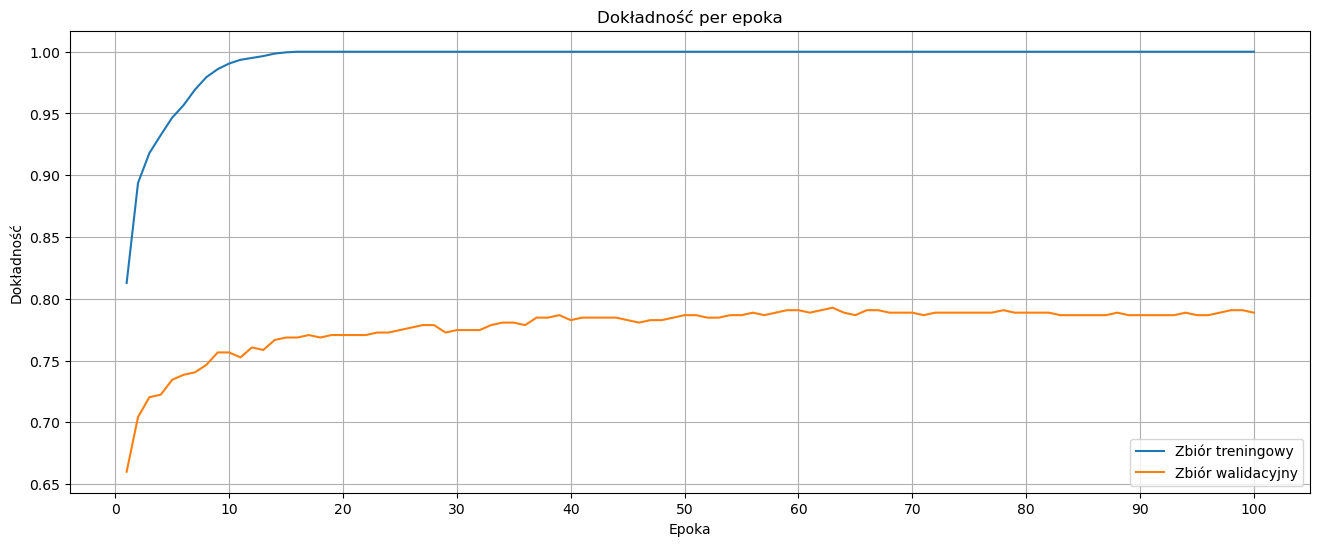

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(best_train_accuracies) + 1), best_train_accuracies, label='Zbiór treningowy')
plt.plot(np.arange(1, len(best_test_accuracies) + 1), best_test_accuracies, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, len(best_test_losses) + 1, step=10))
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

# XGboost loss per epoch

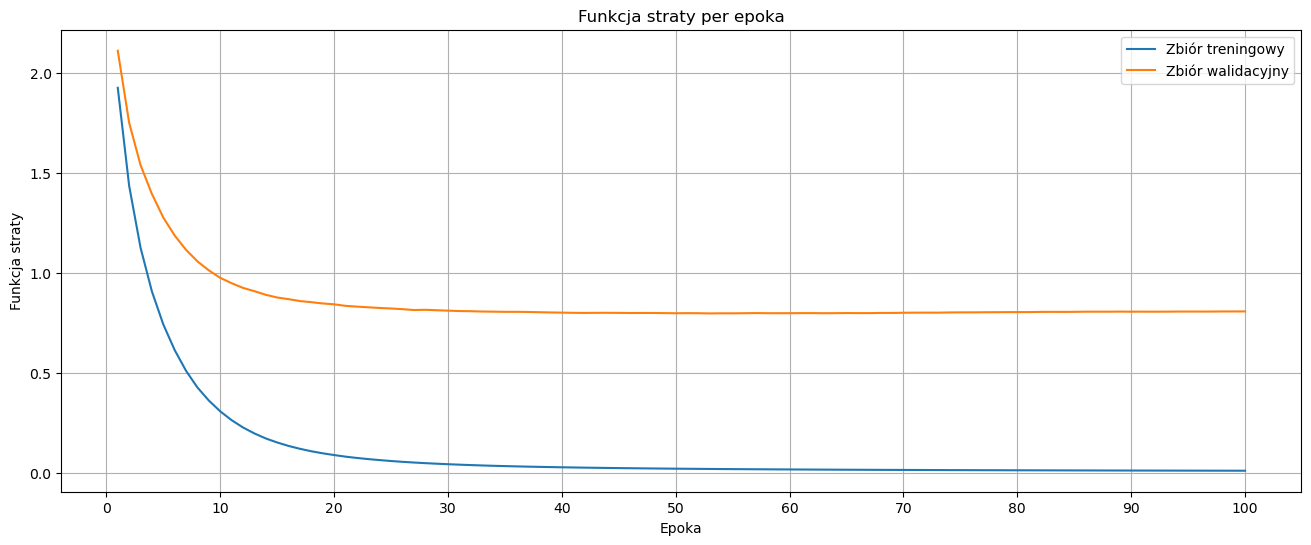

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(best_train_losses) + 1), best_train_losses, label='Zbiór treningowy')
plt.plot(np.arange(1, len(best_test_losses) + 1), best_test_losses, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, len(best_test_losses) + 1, step=10))
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost confusion matrix

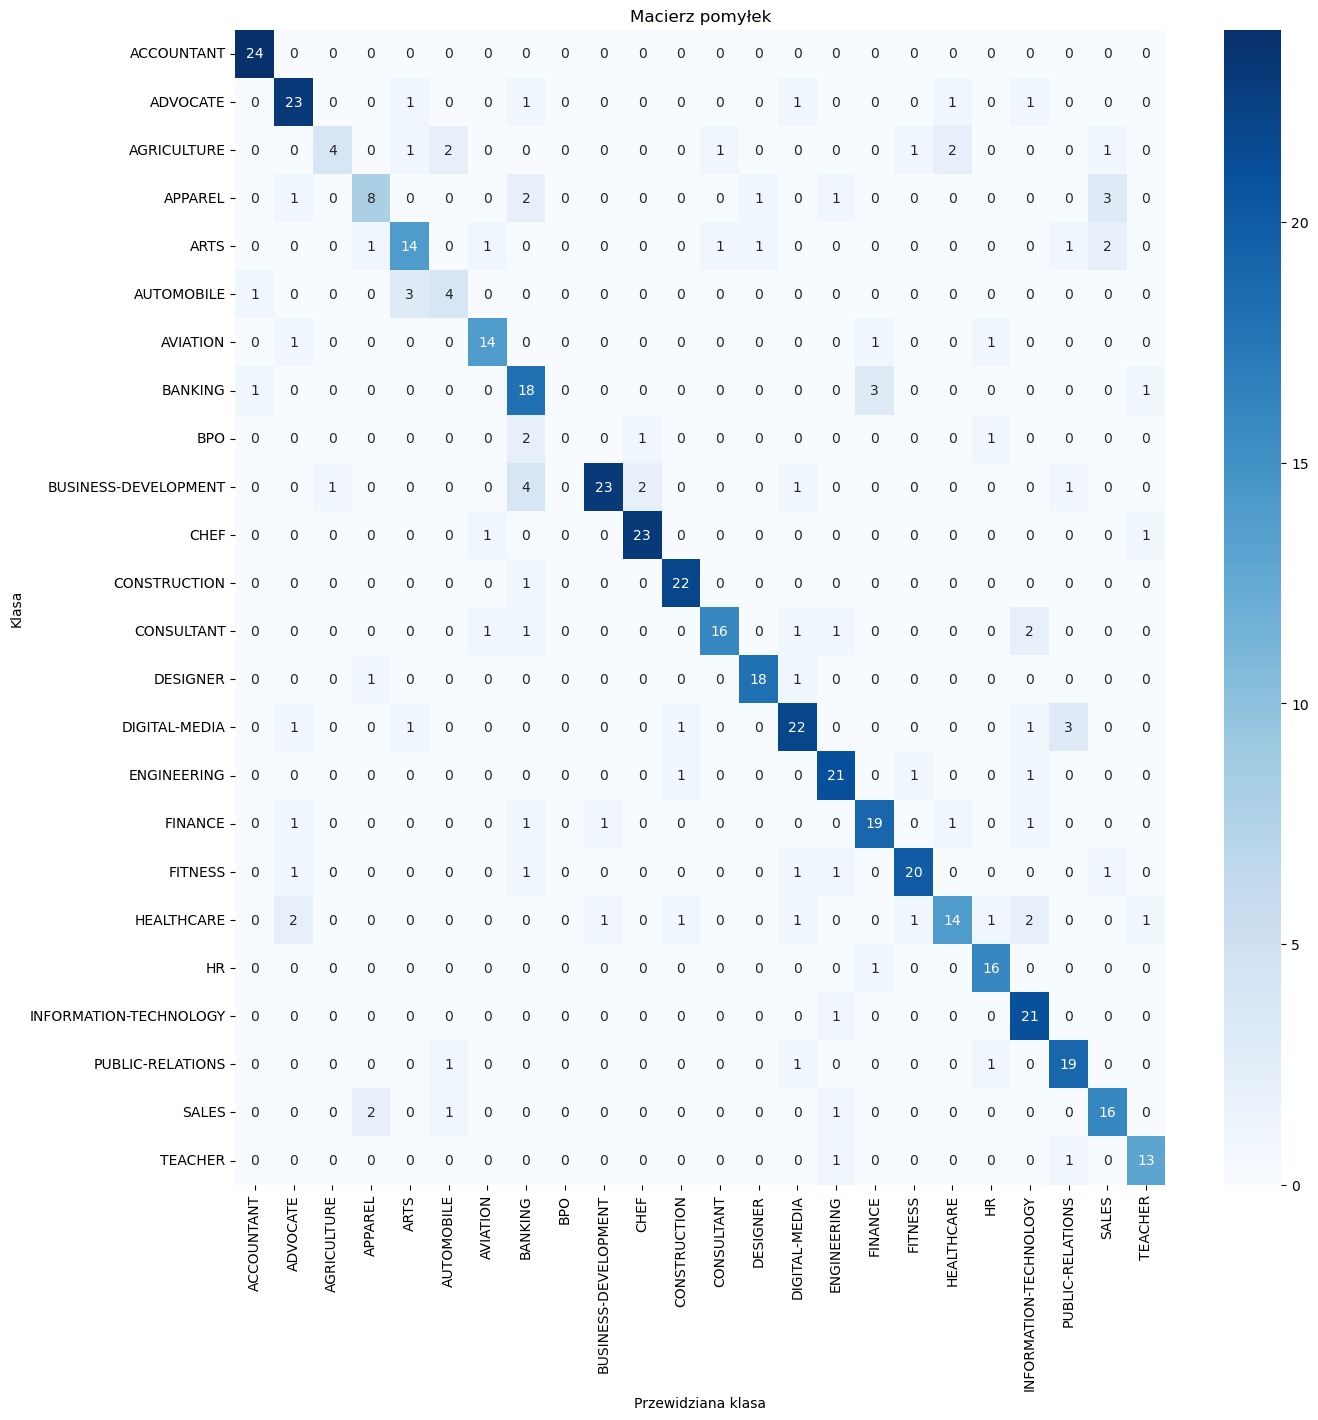

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Klasa')
plt.show()

# XGBoost accuracy per class

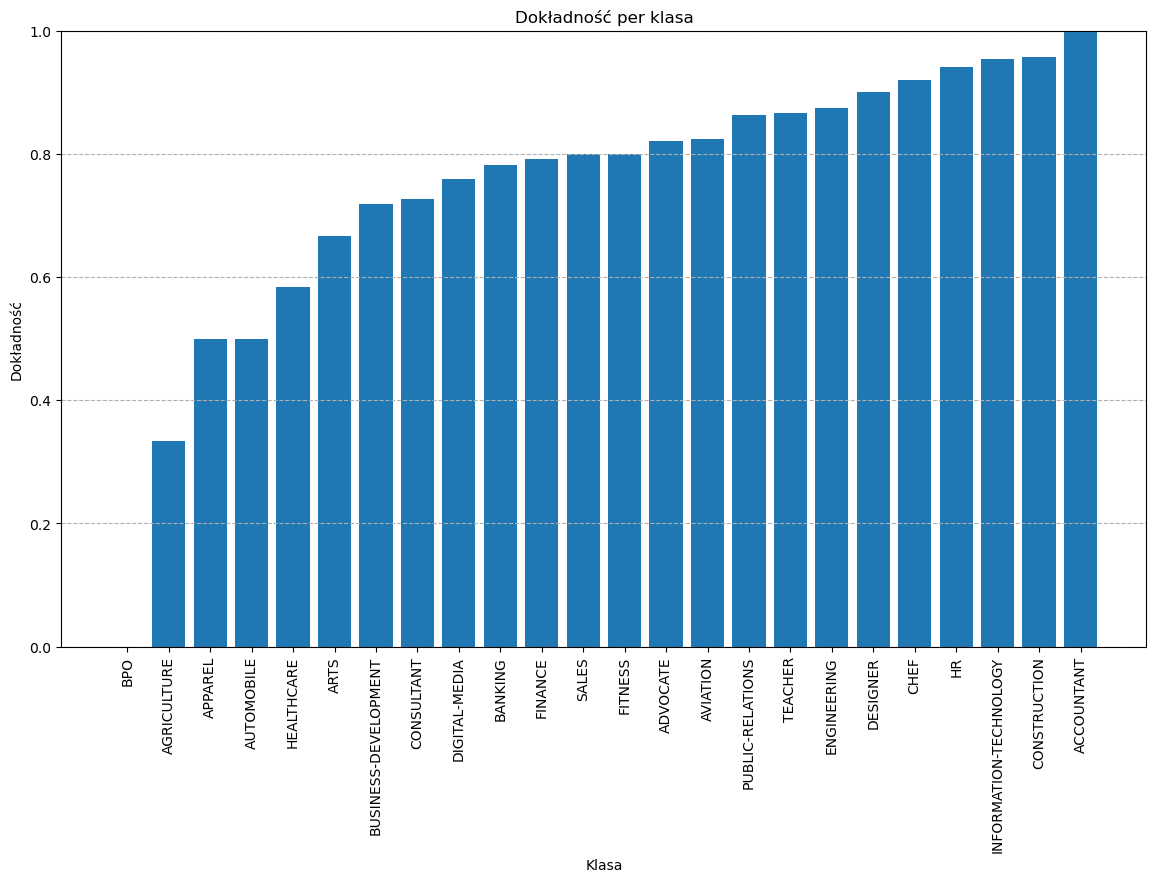

In [17]:
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

classes = label_encoder.classes_

sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = class_accuracies[sorted_indices]
sorted_classes = classes[sorted_indices]

plt.figure(figsize=(14, 8))
plt.bar(sorted_classes, sorted_accuracies)
plt.xlabel('Klasa')
plt.ylabel('Dokładność')
plt.title('Dokładność per klasa')
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--')
plt.show()

# XGBoost Gini and ROC

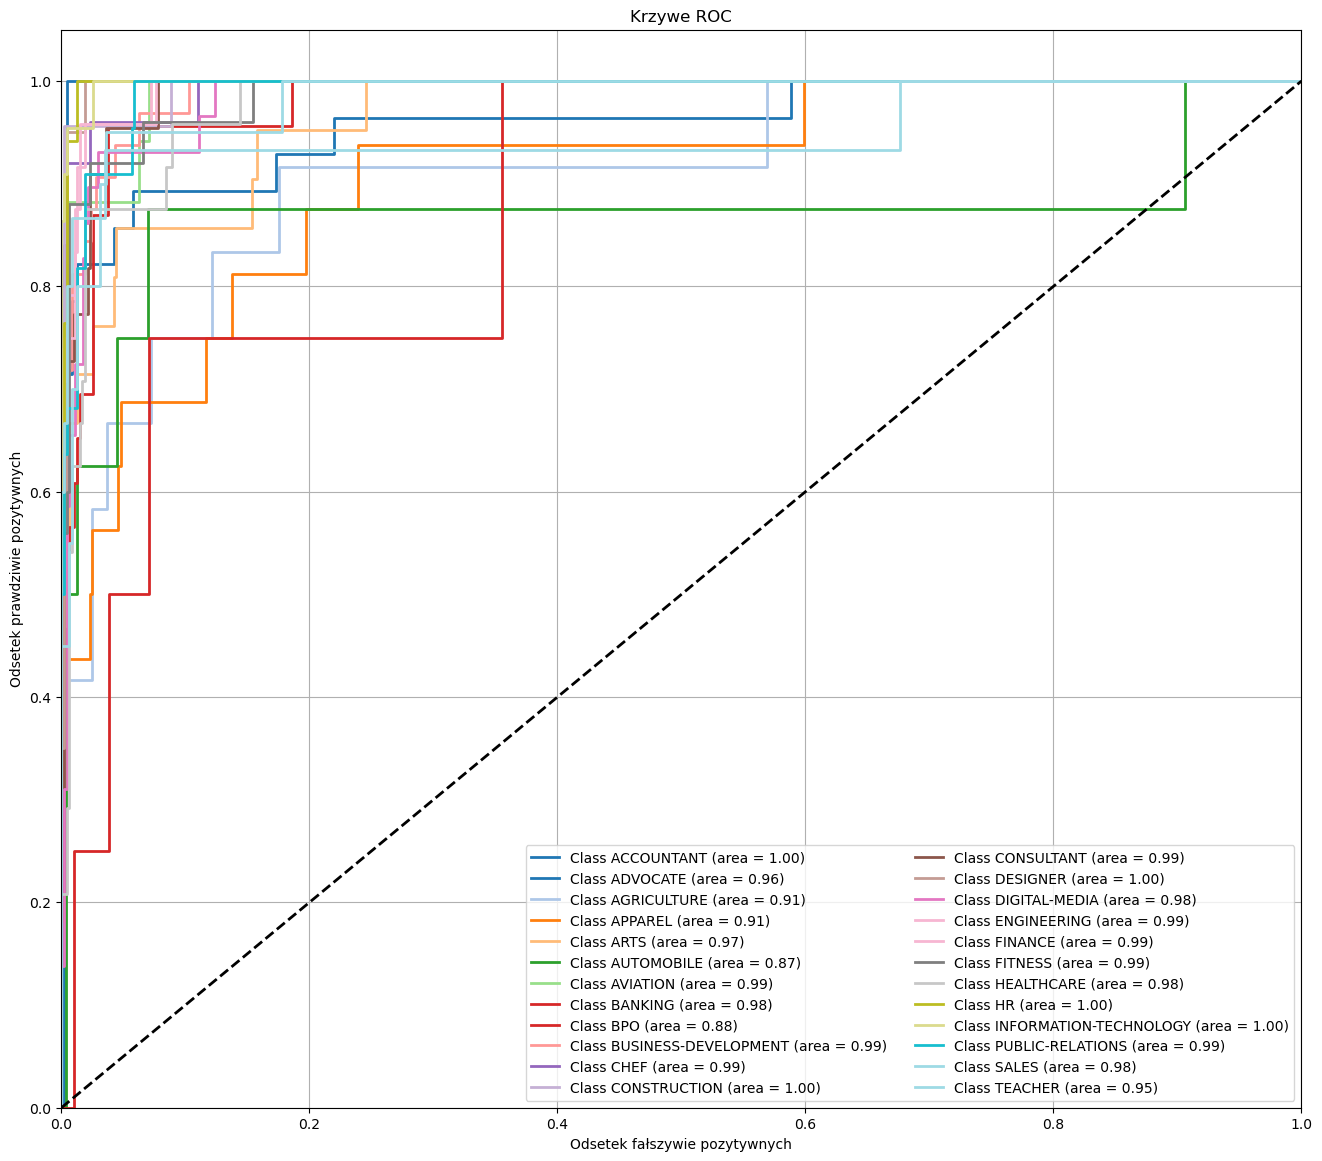

Gini: 0.9416259155292781


In [18]:
n_classes = len(label_encoder.classes_)
colors = cm.get_cmap('tab20', n_classes)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 14))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')

plt.legend(loc="lower right", bbox_to_anchor=(1, 0), ncol=2)

plt.grid(True)
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini: {gini}')

# Save model

In [19]:
with open(SERIALIZED_MODEL_FILENAME, "wb") as file:
    pickle.dump(best_model, file)

In [6]:
with open(SERIALIZED_VECTORIZER_FILENAME, "wb") as file:
    pickle.dump(vectorizer, file)